In [1]:
!git clone https://github.com/uvavision/AMC-grounding.git

Cloning into 'AMC-grounding'...
remote: Enumerating objects: 169, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 169 (delta 33), reused 61 (delta 12), pack-reused 65 (from 1)
Receiving objects: 100% (169/169), 11.77 MiB | 41.41 MiB/s, done.
Resolving deltas: 100% (49/49), done.


In [2]:
%cd AMC-grounding

/content/AMC-grounding


In [3]:
file_path = 'models/xbert.py'

with open(file_path, 'r') as f:
    lines = f.readlines()
new_lines = [line for line in lines if 'tokenizer_class=' not in line]
with open(file_path, 'w') as f:
    f.writelines(new_lines)

In [4]:
  import os
  import numpy as np
  import random
  import json
  from pathlib import Path
  import re
  from functools import partial
  import torch
  import torch.nn as nn
  import torch.nn.functional as F

  from models.vit import interpolate_pos_embed, VisionTransformer
  from models.tokenization_bert import BertTokenizer
  from models.xbert import BertConfig, BertModel
  from models.model_eval import ALBEF

  from torchvision import transforms
  from PIL import Image
  from matplotlib import pyplot as plt
  import cv2
  from skimage import transform as skimage_transform
  from scipy.ndimage import filters
  import warnings
  warnings.filterwarnings('ignore')
  import os

/usr/local/lib/python3.11/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


# Step 1: Load Model

In [5]:
torch.__version__

'2.6.0+cu124'

In [6]:
bert_config_path = 'configs/config_bert.json'

In [7]:
def getAttMap(img, attMap, blur = True, overlap = True):
    attMap -= attMap.min()
    if attMap.max() > 0:
        attMap /= attMap.max()
    attMap = skimage_transform.resize(attMap, (img.shape[:2]), order = 3, mode = 'constant')
    if blur:
        attMap = filters.gaussian_filter(attMap, 0.02*max(img.shape[:2]))
        attMap -= attMap.min()
        attMap /= attMap.max()
    cmap = plt.get_cmap('jet')
    attMapV = cmap(attMap)
    attMapV = np.delete(attMapV, 3, 2)
    if overlap:
        attMap = 1*(1-attMap**0.7).reshape(attMap.shape + (1,))*img + (attMap**0.7).reshape(attMap.shape+(1,)) * attMapV
    return attMap


def pre_caption(caption,max_words=50):
    caption = re.sub(
        r"([,.'!?\"()*#:;~])",
        '',
        caption.lower(),
    ).replace('-', ' ').replace('/', ' ')

    caption = re.sub(
        r"\s{2,}",
        ' ',
        caption,
    )
    caption = caption.rstrip('\n')
    caption = caption.strip(' ')

    #truncate caption
    caption_words = caption.split(' ')
    if len(caption_words)>max_words:
        caption = ' '.join(caption_words[:max_words])
    return caption

"""
def get_phrase_gradcam(text, image, model):
    text_input = tokenizer(text, return_tensors="pt")
    image = image.cuda()
    text_input = text_input.to(image.device)
    output = model(image, text_input)"""

def get_phrase_gradcam(text, image, model, tokenizer):
    text_input = tokenizer(text, return_tensors="pt")

    if hasattr(image, 'pixel_values'):
        image = image.pixel_values

    image = image.cuda()
    text_input = text_input.to(image.device)

    output = model(image, text_input)
    loss = output[:,1].sum()
    model.zero_grad()
    loss.backward()

    with torch.no_grad():
        mask = text_input.attention_mask.view(text_input.attention_mask.size(0),1,-1,1,1)

        grads=model.text_encoder.base_model.base_model.encoder.layer[block_num].crossattention.self.get_attn_gradients()
        cams=model.text_encoder.base_model.base_model.encoder.layer[block_num].crossattention.self.get_attention_map()

        cams = cams[:, :, :, 1:].reshape(image.size(0), 12, -1, 16, 16) * mask
        grads = grads[:, :, :, 1:].clamp(0).reshape(image.size(0), 12, -1, 16, 16) * mask

        gradcam = cams * grads
        gradcam = gradcam.mean(1).mean(1)
    return gradcam


class VL_Transformer_ITM(nn.Module):
    def __init__(self,
                 text_encoder = None,
                 config_bert = ''
                 ):
        super().__init__()

        bert_config = BertConfig.from_json_file(config_bert)

        self.visual_encoder = VisionTransformer(
            img_size=256, patch_size=16, embed_dim=768, depth=12, num_heads=12,
            mlp_ratio=4, qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6))

        self.text_encoder = BertModel.from_pretrained(text_encoder, config=bert_config, add_pooling_layer=False)

        self.itm_head = nn.Linear(768, 2)


    def forward(self, image, text):
        image_embeds = self.visual_encoder(image)

        image_atts = torch.ones(image_embeds.size()[:-1],dtype=torch.long).to(image.device)

        output = self.text_encoder(text.input_ids,
                                attention_mask = text.attention_mask,
                                encoder_hidden_states = image_embeds,
                                encoder_attention_mask = image_atts,
                                return_dict = True,
                               )

        vl_embeddings = output.last_hidden_state[:,0,:]
        vl_output = self.itm_head(vl_embeddings)
        return vl_output

In [8]:
file_path = 'models/xbert.py'
with open(file_path, 'r') as file:
    code = file.read()

code = code.replace('tokenizer.vocab', 'tokenizer.get_vocab()')

with open(file_path, 'w') as file:
    file.write(code)

In [9]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', use_fast=False)
model = VL_Transformer_ITM(text_encoder='bert-base-uncased', config_bert=bert_config_path)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [10]:
import gdown

In [11]:
output_base = '/content/AMC-grounding/best_models'
os.makedirs(output_base, exist_ok=True)

In [12]:
destination='/content/AMC-grounding/best_models/best_refcoco.pth'
gdown.download(f'https://drive.google.com/uc?id=1FaTMaB2hSaDlk4fp5ahx-rKT5coE9ci4',destination)

Downloading...
From (original): https://drive.google.com/uc?id=1FaTMaB2hSaDlk4fp5ahx-rKT5coE9ci4
From (redirected): https://drive.google.com/uc?id=1FaTMaB2hSaDlk4fp5ahx-rKT5coE9ci4&confirm=t&uuid=a9c3f222-6626-4833-9b5d-f453bb7c55e9
To: /content/AMC-grounding/best_models/best_refcoco.pth
100%|██████████| 1.81G/1.81G [00:12<00:00, 140MB/s]


'/content/AMC-grounding/best_models/best_refcoco.pth'

In [13]:
model_path = 'best_models/best_refcoco.pth'
checkpoint = torch.load(model_path, map_location='cpu')

In [14]:
print('load pretraining model.')
state_dict = checkpoint['model']
pos_embed_reshaped = interpolate_pos_embed(state_dict['visual_encoder.pos_embed'],model.visual_encoder)
state_dict['visual_encoder.pos_embed'] = pos_embed_reshaped

for key in list(state_dict.keys()):
    if 'bert' in key:
        encoder_key = key.replace('bert.','')
        state_dict[encoder_key] = state_dict[key]
        del state_dict[key]
msg = model.load_state_dict(state_dict,strict=False)
model = model.eval()
model = model.cuda()

load pretraining model.


In [15]:
block_num = 8
model.text_encoder.base_model.base_model.encoder.layer[block_num].crossattention.self.save_attention = True

# 2. Load Image and Text

In [16]:
normalize = transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

transform = transforms.Compose([
    transforms.Resize((256,256),interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    normalize,
])

In [17]:
output_base = '/content/AMC-grounding/test_images'
os.makedirs(output_base, exist_ok=True)

In [18]:
destination='/content/AMC-grounding/test_images/coco1.png'
gdown.download(f'https://drive.google.com/uc?id=1_N3aNzjjs2WfO1Na3fs5soKKfB2l2HSs',destination)

Downloading...
From: https://drive.google.com/uc?id=1_N3aNzjjs2WfO1Na3fs5soKKfB2l2HSs
To: /content/AMC-grounding/test_images/coco1.png
100%|██████████| 216k/216k [00:00<00:00, 74.5MB/s]


'/content/AMC-grounding/test_images/coco1.png'

In [19]:
image_path = '/content/AMC-grounding/test_images/coco1.png'
image_pil = Image.open(image_path).convert('RGB')
image = transform(image_pil).unsqueeze(0)

In [20]:
w,h = image_pil.size

caption = 'a black and white cat'
text = pre_caption(caption)

# 3. Show GradCAM Results

Text(0.5, 0, 'a black and white cat')

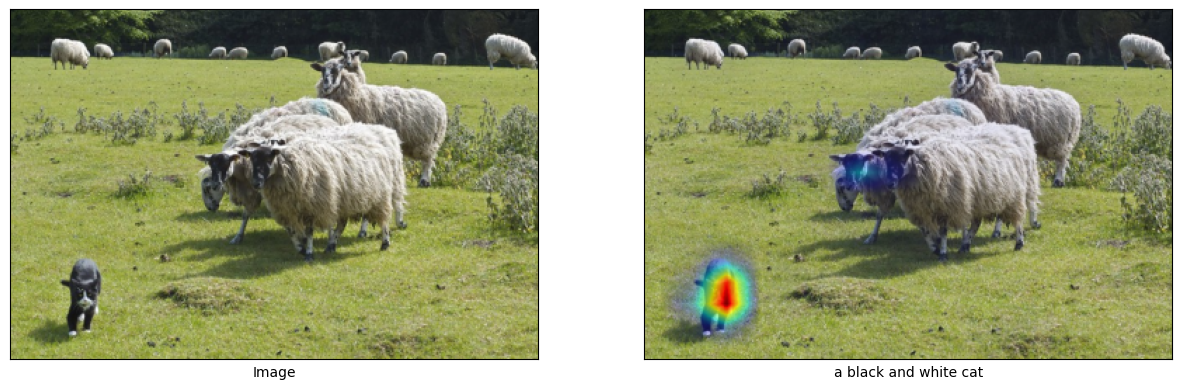

In [21]:
gradcam = get_phrase_gradcam(text, image, model, tokenizer)
gradcam_shown = gradcam.view(1,1,16,16)
gradcam_shown = F.interpolate(
    gradcam_shown, (256,256), mode="bilinear", align_corners=False
).squeeze()

fig, ax = plt.subplots(1, 2, figsize=(15,20))

rgb_image = cv2.imread(image_path)[:, :, ::-1]
rgb_image = np.float32(rgb_image) / 255

ax[0].imshow(rgb_image)
ax[0].set_yticks([])
ax[0].set_xticks([])
ax[0].set_xlabel("Image")
word = text
#gradcam_image = getAttMap(rgb_image, gradcam_shown.detach().cpu(), blur = False,overlap = True)
gradcam_numpy = gradcam_shown.detach().cpu().numpy()

gradcam_image = getAttMap(rgb_image, gradcam_numpy, blur=False, overlap=True)

ax[1].imshow(gradcam_image)
ax[1].set_yticks([])
ax[1].set_xticks([])
ax[1].set_xlabel(word)

###Creating Saliency maps directly

##Otsu Thresholding

In [22]:
zip_path = '/content/AMC-grounding/cosod.zip'
dataset_root = '/content/AMC-grounding/cosod/CoSOD3k/Image'
gdown.download('https://drive.google.com/uc?id=1-zkz9Zu3vvT7JB_n7jTZYiTxBpoigER6', zip_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1-zkz9Zu3vvT7JB_n7jTZYiTxBpoigER6
From (redirected): https://drive.google.com/uc?id=1-zkz9Zu3vvT7JB_n7jTZYiTxBpoigER6&confirm=t&uuid=339729a1-93c7-48fd-a609-cc4fb6825027
To: /content/AMC-grounding/cosod.zip
100%|██████████| 439M/439M [00:07<00:00, 55.1MB/s]


'/content/AMC-grounding/cosod.zip'

In [23]:
import zipfile
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/AMC-grounding/cosod')

In [24]:
dataset_root = '/content/AMC-grounding/cosod/CoSOD3k/Image'
output_root = '/content/AMC-grounding/cosod_saliency_maps'

os.makedirs(output_root, exist_ok=True)

categories = sorted(os.listdir(dataset_root))

for category in categories:
    category_path = os.path.join(dataset_root, category)
    if not os.path.isdir(category_path):
        continue

    print(f'Processing category: {category}')
    os.makedirs(os.path.join(output_root, category), exist_ok=True)

    caption = category
    text = pre_caption(caption)

    image_files = glob.glob(os.path.join(category_path, '*'))

    for image_file in tqdm(image_files, desc=f'{category} images'):
        image_pil = Image.open(image_file).convert('RGB')
        image = transform(image_pil).unsqueeze(0).cuda()

        gradcam = get_phrase_gradcam(text, image, model,tokenizer)
        gradcam_shown = gradcam.view(1,1,16,16)
        gradcam_shown = F.interpolate(gradcam_shown, (256,256), mode="bilinear", align_corners=False).squeeze()
        gradcam_numpy = gradcam_shown.detach().cpu().numpy()

        otsu_thresh = threshold_otsu(gradcam_numpy)
        binary_saliency = gradcam_numpy > otsu_thresh

        binary_resized = skimage_transform.resize(binary_saliency, image_pil.size[::-1], order=0, preserve_range=True).astype(np.uint8)

        output_path = os.path.join(output_root, category, os.path.basename(image_file))
        output_path = os.path.splitext(output_path)[0] + '_saliency.png'
        Image.fromarray((binary_resized * 255).astype(np.uint8)).save(output_path)

Processing category: airplane


airplane images: 100%|██████████| 30/30 [00:02<00:00, 10.43it/s]


Processing category: ant


ant images: 100%|██████████| 22/22 [00:02<00:00, 10.71it/s]


Processing category: antelope


antelope images: 100%|██████████| 28/28 [00:02<00:00, 10.94it/s]


Processing category: apple


apple images: 100%|██████████| 18/18 [00:02<00:00,  7.67it/s]


Processing category: armadillo


armadillo images: 100%|██████████| 30/30 [00:03<00:00,  9.95it/s]


Processing category: artichoke


artichoke images: 100%|██████████| 14/14 [00:01<00:00, 10.96it/s]


Processing category: axe


axe images: 100%|██████████| 29/29 [00:02<00:00, 10.72it/s]


Processing category: baby_bed


baby_bed images: 100%|██████████| 11/11 [00:01<00:00, 10.90it/s]


Processing category: bagel


bagel images: 100%|██████████| 24/24 [00:02<00:00, 10.90it/s]


Processing category: banana


banana images: 100%|██████████| 18/18 [00:01<00:00,  9.38it/s]


Processing category: band_aid


band_aid images: 100%|██████████| 30/30 [00:03<00:00,  9.83it/s]


Processing category: banjo


banjo images: 100%|██████████| 20/20 [00:01<00:00, 10.92it/s]


Processing category: baseball


baseball images: 100%|██████████| 28/28 [00:02<00:00, 10.97it/s]


Processing category: basketball


basketball images: 100%|██████████| 9/9 [00:00<00:00, 10.93it/s]


Processing category: beaker


beaker images: 100%|██████████| 20/20 [00:01<00:00, 11.07it/s]


Processing category: bear


bear images: 100%|██████████| 30/30 [00:03<00:00,  9.37it/s]


Processing category: bee


bee images: 100%|██████████| 30/30 [00:02<00:00, 10.73it/s]


Processing category: bell_pepper


bell_pepper images: 100%|██████████| 18/18 [00:01<00:00, 10.21it/s]


Processing category: bench


bench images: 100%|██████████| 18/18 [00:01<00:00, 10.80it/s]


Processing category: bicycle


bicycle images: 100%|██████████| 18/18 [00:01<00:00, 10.86it/s]


Processing category: binder


binder images: 100%|██████████| 8/8 [00:00<00:00, 10.70it/s]


Processing category: bird


bird images: 100%|██████████| 29/29 [00:03<00:00,  9.06it/s]


Processing category: bookshelf


bookshelf images: 100%|██████████| 18/18 [00:01<00:00,  9.43it/s]


Processing category: bow


bow images: 100%|██████████| 8/8 [00:00<00:00, 10.52it/s]


Processing category: bow_tie


bow_tie images: 100%|██████████| 14/14 [00:01<00:00, 10.63it/s]


Processing category: bowl


bowl images: 100%|██████████| 9/9 [00:00<00:00, 10.83it/s]


Processing category: brassiere


brassiere images: 100%|██████████| 11/11 [00:01<00:00, 10.75it/s]


Processing category: bus


bus images: 100%|██████████| 30/30 [00:02<00:00, 10.72it/s]


Processing category: butterfly


butterfly images: 100%|██████████| 30/30 [00:03<00:00,  8.99it/s]


Processing category: camel


camel images: 100%|██████████| 30/30 [00:02<00:00, 10.67it/s]


Processing category: can_opener


can_opener images: 100%|██████████| 13/13 [00:01<00:00, 10.06it/s]


Processing category: car


car images: 100%|██████████| 29/29 [00:02<00:00, 10.36it/s]


Processing category: cart


cart images: 100%|██████████| 10/10 [00:00<00:00, 10.59it/s]


Processing category: cattle


cattle images: 100%|██████████| 25/25 [00:02<00:00, 10.36it/s]


Processing category: cello


cello images: 100%|██████████| 7/7 [00:00<00:00,  8.38it/s]


Processing category: centipede


centipede images: 100%|██████████| 22/22 [00:04<00:00,  5.19it/s]


Processing category: chain_saw


chain_saw images: 100%|██████████| 9/9 [00:01<00:00,  8.65it/s]


Processing category: chime


chime images: 100%|██████████| 28/28 [00:02<00:00, 10.77it/s]


Processing category: cocktail_shaker


cocktail_shaker images: 100%|██████████| 13/13 [00:01<00:00, 10.53it/s]


Processing category: computer_keyboard


computer_keyboard images: 100%|██████████| 10/10 [00:00<00:00, 10.69it/s]


Processing category: computer_mouse


computer_mouse images: 100%|██████████| 26/26 [00:02<00:00,  9.08it/s]


Processing category: cream


cream images: 100%|██████████| 24/24 [00:02<00:00, 10.21it/s]


Processing category: croquet_ball


croquet_ball images: 100%|██████████| 26/26 [00:02<00:00,  8.68it/s]


Processing category: crutch


crutch images: 100%|██████████| 23/23 [00:02<00:00, 10.37it/s]


Processing category: cucumber


cucumber images: 100%|██████████| 19/19 [00:01<00:00, 10.66it/s]


Processing category: cup_or_mug


cup_or_mug images: 100%|██████████| 19/19 [00:02<00:00,  9.13it/s]


Processing category: digital_clock


digital_clock images: 100%|██████████| 14/14 [00:01<00:00,  9.20it/s]


Processing category: dog


dog images: 100%|██████████| 30/30 [00:02<00:00, 10.63it/s]


Processing category: domestic_cat


domestic_cat images: 100%|██████████| 30/30 [00:02<00:00, 10.24it/s]


Processing category: dragonfly


dragonfly images: 100%|██████████| 30/30 [00:02<00:00, 10.50it/s]


Processing category: drum


drum images: 100%|██████████| 12/12 [00:01<00:00,  9.62it/s]


Processing category: dumbbell


dumbbell images: 100%|██████████| 21/21 [00:02<00:00,  8.91it/s]


Processing category: electric_fan


electric_fan images: 100%|██████████| 12/12 [00:01<00:00, 10.50it/s]


Processing category: elephant


elephant images: 100%|██████████| 30/30 [00:03<00:00,  8.15it/s]


Processing category: face_powder


face_powder images: 100%|██████████| 21/21 [00:01<00:00, 10.92it/s]


Processing category: fig


fig images: 100%|██████████| 19/19 [00:01<00:00, 10.72it/s]


Processing category: flower_pot


flower_pot images: 100%|██████████| 10/10 [00:01<00:00,  9.70it/s]


Processing category: flute


flute images: 100%|██████████| 21/21 [00:02<00:00,  8.13it/s]


Processing category: fox


fox images: 100%|██████████| 30/30 [00:02<00:00, 10.63it/s]


Processing category: french_horn


french_horn images: 100%|██████████| 4/4 [00:00<00:00, 10.52it/s]


Processing category: frog


frog images: 100%|██████████| 29/29 [00:02<00:00, 10.73it/s]


Processing category: frying_pan


frying_pan images: 100%|██████████| 17/17 [00:01<00:00, 10.57it/s]


Processing category: giant_panda


giant_panda images: 100%|██████████| 30/30 [00:03<00:00,  9.66it/s]


Processing category: goldfish


goldfish images: 100%|██████████| 30/30 [00:03<00:00,  9.84it/s]


Processing category: golf_ball


golf_ball images: 100%|██████████| 28/28 [00:02<00:00, 10.28it/s]


Processing category: golfcart


golfcart images: 100%|██████████| 14/14 [00:01<00:00, 10.55it/s]


Processing category: guitar


guitar images: 100%|██████████| 21/21 [00:01<00:00, 10.75it/s]


Processing category: hair_dryer


hair_dryer images: 100%|██████████| 22/22 [00:02<00:00, 10.14it/s]


Processing category: hair_spray


hair_spray images: 100%|██████████| 20/20 [00:02<00:00,  8.96it/s]


Processing category: hamburger


hamburger images: 100%|██████████| 21/21 [00:01<00:00, 10.65it/s]


Processing category: hammer


hammer images: 100%|██████████| 13/13 [00:01<00:00, 10.70it/s]


Processing category: hamster


hamster images: 100%|██████████| 21/21 [00:01<00:00, 10.76it/s]


Processing category: harmonica


harmonica images: 100%|██████████| 14/14 [00:01<00:00, 10.39it/s]


Processing category: harp


harp images: 100%|██████████| 9/9 [00:00<00:00, 10.10it/s]


Processing category: hat_with_a_wide_brim


hat_with_a_wide_brim images: 100%|██████████| 27/27 [00:02<00:00, 10.01it/s]


Processing category: head_cabbage


head_cabbage images: 100%|██████████| 9/9 [00:01<00:00,  8.72it/s]


Processing category: helmet


helmet images: 100%|██████████| 8/8 [00:00<00:00,  9.00it/s]


Processing category: hippopotamus


hippopotamus images: 100%|██████████| 30/30 [00:02<00:00, 10.67it/s]


Processing category: horse


horse images: 100%|██████████| 30/30 [00:02<00:00, 10.52it/s]


Processing category: iPod


iPod images: 100%|██████████| 22/22 [00:02<00:00, 10.69it/s]


Processing category: isopod


isopod images: 100%|██████████| 27/27 [00:02<00:00,  9.92it/s]


Processing category: jellyfish


jellyfish images: 100%|██████████| 29/29 [00:02<00:00,  9.73it/s]


Processing category: koala_bear


koala_bear images: 100%|██████████| 30/30 [00:02<00:00, 10.65it/s]


Processing category: ladybug


ladybug images: 100%|██████████| 30/30 [00:02<00:00, 10.50it/s]


Processing category: lamp


lamp images: 100%|██████████| 9/9 [00:00<00:00, 10.57it/s]


Processing category: laptop


laptop images: 100%|██████████| 11/11 [00:01<00:00, 10.38it/s]


Processing category: lemon


lemon images: 100%|██████████| 19/19 [00:02<00:00,  9.29it/s]


Processing category: lion


lion images: 100%|██████████| 21/21 [00:04<00:00,  4.90it/s]


Processing category: lipstick


lipstick images: 100%|██████████| 23/23 [00:02<00:00, 10.66it/s]


Processing category: lizard


lizard images: 100%|██████████| 28/28 [00:02<00:00, 10.74it/s]


Processing category: lobster


lobster images: 100%|██████████| 16/16 [00:02<00:00,  6.63it/s]


Processing category: maraca


maraca images: 100%|██████████| 28/28 [00:02<00:00,  9.37it/s]


Processing category: microwave


microwave images: 100%|██████████| 8/8 [00:00<00:00, 10.64it/s]


Processing category: milk_can


milk_can images: 100%|██████████| 16/16 [00:01<00:00, 10.67it/s]


Processing category: monkey


monkey images: 100%|██████████| 30/30 [00:02<00:00, 10.71it/s]


Processing category: motorcycle


motorcycle images: 100%|██████████| 20/20 [00:01<00:00, 10.61it/s]


Processing category: mushroom


mushroom images: 100%|██████████| 30/30 [00:03<00:00,  9.52it/s]


Processing category: nail


nail images: 100%|██████████| 22/22 [00:02<00:00,  9.88it/s]


Processing category: oboe


oboe images: 100%|██████████| 14/14 [00:01<00:00, 10.70it/s]


Processing category: orange


orange images: 100%|██████████| 11/11 [00:01<00:00, 10.07it/s]


Processing category: otter


otter images: 100%|██████████| 30/30 [00:02<00:00, 10.71it/s]


Processing category: pencil_box


pencil_box images: 100%|██████████| 11/11 [00:01<00:00, 10.61it/s]


Processing category: perfume


perfume images: 100%|██████████| 27/27 [00:02<00:00, 10.15it/s]


Processing category: person


person images: 100%|██████████| 21/21 [00:02<00:00,  9.06it/s]


Processing category: piano


piano images: 100%|██████████| 5/5 [00:00<00:00, 10.37it/s]


Processing category: pineapple


pineapple images: 100%|██████████| 21/21 [00:01<00:00, 10.59it/s]


Processing category: pitcher


pitcher images: 100%|██████████| 21/21 [00:02<00:00, 10.47it/s]


Processing category: pizza


pizza images: 100%|██████████| 17/17 [00:01<00:00, 10.43it/s]


Processing category: pomegranate


pomegranate images: 100%|██████████| 20/20 [00:01<00:00, 10.55it/s]


Processing category: popsicle


popsicle images: 100%|██████████| 22/22 [00:02<00:00,  9.69it/s]


Processing category: porcupine


porcupine images: 100%|██████████| 30/30 [00:03<00:00,  9.62it/s]


Processing category: power_drill


power_drill images: 100%|██████████| 17/17 [00:01<00:00, 10.55it/s]


Processing category: pretzel


pretzel images: 100%|██████████| 10/10 [00:00<00:00, 10.71it/s]


Processing category: punching_bag


punching_bag images: 100%|██████████| 13/13 [00:01<00:00, 10.48it/s]


Processing category: purse


purse images: 100%|██████████| 20/20 [00:01<00:00, 10.59it/s]


Processing category: rabbit


rabbit images: 100%|██████████| 30/30 [00:06<00:00,  4.91it/s]


Processing category: ray


ray images: 100%|██████████| 29/29 [00:04<00:00,  6.23it/s]


Processing category: red_panda


red_panda images: 100%|██████████| 30/30 [00:04<00:00,  6.21it/s]


Processing category: refrigerator


refrigerator images: 100%|██████████| 11/11 [00:02<00:00,  4.59it/s]


Processing category: remote_control


remote_control images: 100%|██████████| 23/23 [00:04<00:00,  5.24it/s]


Processing category: rubber_eraser


rubber_eraser images: 100%|██████████| 23/23 [00:03<00:00,  6.95it/s]


Processing category: rugby_ball


rugby_ball images: 100%|██████████| 12/12 [00:01<00:00,  7.06it/s]


Processing category: salt_or_pepper_shaker


salt_or_pepper_shaker images: 100%|██████████| 30/30 [00:06<00:00,  4.97it/s]


Processing category: scorpion


scorpion images: 100%|██████████| 30/30 [00:05<00:00,  5.61it/s]


Processing category: screwdriver


screwdriver images: 100%|██████████| 19/19 [00:01<00:00,  9.84it/s]


Processing category: seal


seal images: 100%|██████████| 27/27 [00:02<00:00,  9.34it/s]


Processing category: sheep


sheep images: 100%|██████████| 30/30 [00:02<00:00, 10.45it/s]


Processing category: skunk


skunk images: 100%|██████████| 30/30 [00:02<00:00, 10.60it/s]


Processing category: snail


snail images: 100%|██████████| 29/29 [00:02<00:00, 10.67it/s]


Processing category: snake


snake images: 100%|██████████| 28/28 [00:03<00:00,  8.89it/s]


Processing category: snowmobile


snowmobile images: 100%|██████████| 10/10 [00:00<00:00, 10.82it/s]


Processing category: snowplow


snowplow images: 100%|██████████| 27/27 [00:02<00:00, 10.79it/s]


Processing category: soap_dispenser


soap_dispenser images: 100%|██████████| 16/16 [00:01<00:00, 10.62it/s]


Processing category: soccer_ball


soccer_ball images: 100%|██████████| 29/29 [00:02<00:00, 10.61it/s]


Processing category: sofa


sofa images: 100%|██████████| 9/9 [00:00<00:00, 10.66it/s]


Processing category: spatula


spatula images: 100%|██████████| 16/16 [00:01<00:00,  9.13it/s]


Processing category: squirrel


squirrel images: 100%|██████████| 30/30 [00:03<00:00,  9.62it/s]


Processing category: starfish


starfish images: 100%|██████████| 29/29 [00:02<00:00, 10.57it/s]


Processing category: stethoscope


stethoscope images: 100%|██████████| 8/8 [00:00<00:00, 10.60it/s]


Processing category: strainer


strainer images: 100%|██████████| 18/18 [00:01<00:00, 10.61it/s]


Processing category: strawberry


strawberry images: 100%|██████████| 15/15 [00:01<00:00, 10.28it/s]


Processing category: swine


swine images: 100%|██████████| 30/30 [00:03<00:00,  9.16it/s]


Processing category: syringe


syringe images: 100%|██████████| 20/20 [00:01<00:00, 10.50it/s]


Processing category: tape_player


tape_player images: 100%|██████████| 26/26 [00:02<00:00, 10.75it/s]


Processing category: tennis_ball


tennis_ball images: 100%|██████████| 28/28 [00:02<00:00, 10.48it/s]


Processing category: tick


tick images: 100%|██████████| 20/20 [00:01<00:00, 10.58it/s]


Processing category: tie


tie images: 100%|██████████| 13/13 [00:01<00:00, 10.47it/s]


Processing category: tiger


tiger images: 100%|██████████| 30/30 [00:03<00:00,  9.26it/s]


Processing category: toaster


toaster images: 100%|██████████| 11/11 [00:01<00:00, 10.82it/s]


Processing category: traffic_light


traffic_light images: 100%|██████████| 21/21 [00:01<00:00, 10.60it/s]


Processing category: train


train images: 100%|██████████| 10/10 [00:00<00:00, 10.76it/s]


Processing category: trumpet


trumpet images: 100%|██████████| 9/9 [00:00<00:00, 10.70it/s]


Processing category: turtle


turtle images: 100%|██████████| 30/30 [00:02<00:00, 10.48it/s]


Processing category: violin


violin images: 100%|██████████| 7/7 [00:00<00:00, 10.63it/s]


Processing category: washer


washer images: 100%|██████████| 10/10 [00:01<00:00,  9.34it/s]


Processing category: water_bottle


water_bottle images: 100%|██████████| 22/22 [00:02<00:00,  9.14it/s]


Processing category: watercraft


watercraft images: 100%|██████████| 22/22 [00:02<00:00, 10.50it/s]


Processing category: whale


whale images: 100%|██████████| 30/30 [00:02<00:00, 10.72it/s]


Processing category: wine_bottle


wine_bottle images: 100%|██████████| 22/22 [00:02<00:00, 10.52it/s]


Processing category: zebra


zebra images: 100%|██████████| 26/26 [00:08<00:00,  3.06it/s]


##DGCNet

In [25]:
%cd ..

/content


In [26]:
!pwd

/content


In [27]:
!git clone https://github.com/AaltoVision/DGC-Net.git

Cloning into 'DGC-Net'...
remote: Enumerating objects: 233, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 233 (delta 8), reused 15 (delta 6), pack-reused 215 (from 1)
Receiving objects: 100% (233/233), 9.05 MiB | 12.36 MiB/s, done.
Resolving deltas: 100% (105/105), done.


In [28]:
#1p1FarlU5byWez_mQC68DZ_eRQKfF9IIf
zip_path = '/content/checkpt.zip'
#dataset_root = '/content/AMC-grounding/cosod/CoSOD3k/Image'
gdown.download('https://drive.google.com/uc?id=1p1FarlU5byWez_mQC68DZ_eRQKfF9IIf', zip_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1p1FarlU5byWez_mQC68DZ_eRQKfF9IIf
From (redirected): https://drive.google.com/uc?id=1p1FarlU5byWez_mQC68DZ_eRQKfF9IIf&confirm=t&uuid=c0843848-b22b-456b-8d54-16fa80d948c8
To: /content/checkpt.zip
100%|██████████| 113M/113M [00:00<00:00, 146MB/s] 


'/content/checkpt.zip'

In [29]:
import zipfile
with zipfile.ZipFile('/content/checkpt.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [30]:
import os
import sys

os.chdir('/content/DGC-Net')


In [31]:
from model import modules
from model import net

DGCNet = net.DGCNet
print("Modules imported successfully!")

Modules imported successfully!


In [32]:
import torch

dgc_model = DGCNet()
checkpoint_path = '/content/pretrained_models/dgc/checkpoint.pth'

#checkpoint_path='/content/pretrained_models/dgcm/checkpoint.pth'

checkpoint = torch.load(checkpoint_path, map_location='cpu')
print("Checkpoint keys:", checkpoint.keys())

dgc_model.load_state_dict(checkpoint['state_dict'])
dgc_model.eval()

print("DGCNet loaded successfully!")

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 68.6MB/s]


Checkpoint keys: dict_keys(['state_dict', 'optimizer'])
DGCNet loaded successfully!


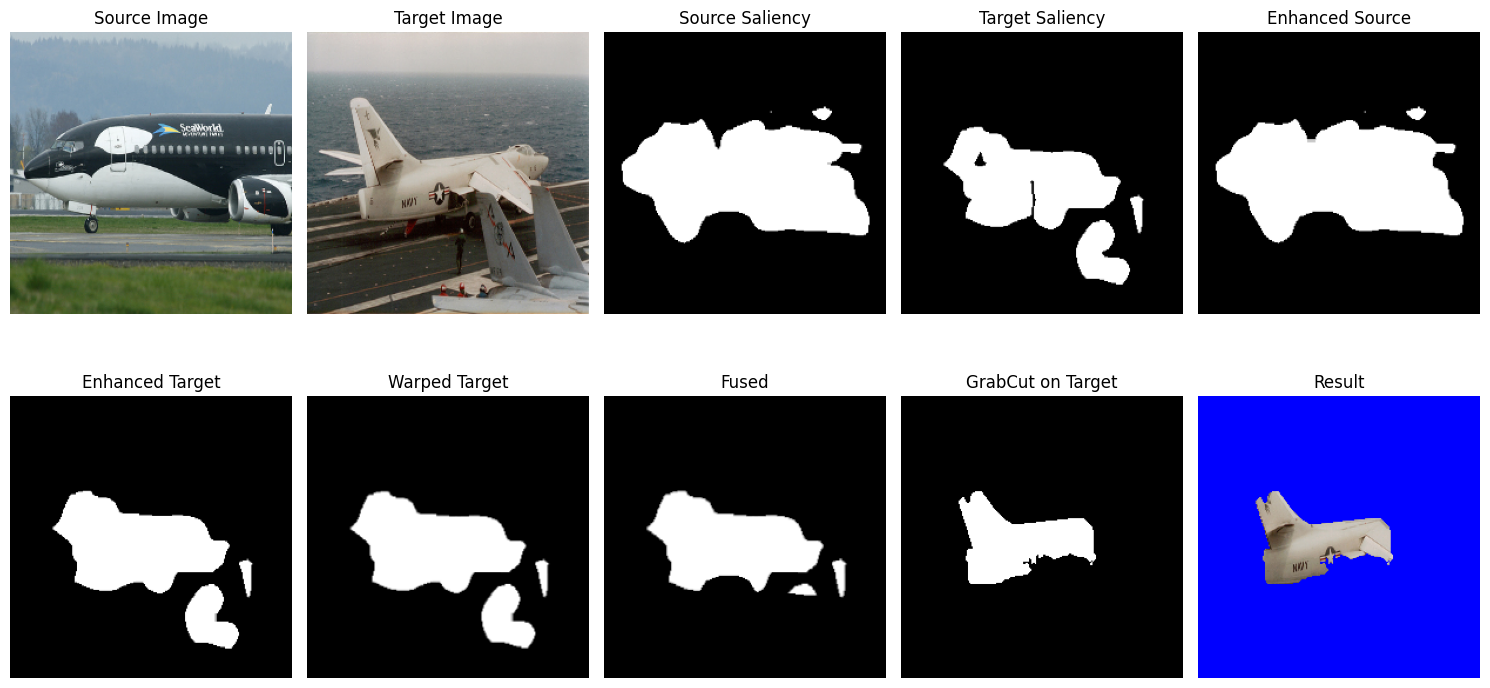

In [33]:
import os
import cv2
import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

# 1. Load Source and Target Images
source_img = cv2.imread('/content/AMC-grounding/cosod/CoSOD3k/Image/airplane/ILSVRC2012_val_00001390.jpg')          # Source image
target_img = cv2.imread('/content/AMC-grounding/cosod/CoSOD3k/Image/airplane/ILSVRC2012_val_00004089.jpg')          # Target image
source_img = cv2.resize(source_img, (240, 240))
target_img = cv2.resize(target_img, (240, 240))

# 2. Load/Generate Initial Saliency Maps (AMC Grounding + Otsu)
# Here, assume you have binary saliency maps (0-1 floats or 0/255 uint8)
source_sal = cv2.imread('/content/AMC-grounding/cosod_saliency_maps/airplane/ILSVRC2012_val_00001390_saliency.png', cv2.IMREAD_GRAYSCALE) / 255.0
target_sal = cv2.imread('/content/AMC-grounding/cosod_saliency_maps/airplane/ILSVRC2012_val_00004089_saliency.png', cv2.IMREAD_GRAYSCALE) / 255.0
source_sal = cv2.resize(source_sal, (240, 240))
target_sal = cv2.resize(target_sal, (240, 240))

# 3. Optionally Enhance Saliency Maps (e.g., morphological closing)
kernel = np.ones((7,7), np.uint8)
source_sal_enh = cv2.morphologyEx(source_sal, cv2.MORPH_CLOSE, kernel)
target_sal_enh = cv2.morphologyEx(target_sal, cv2.MORPH_CLOSE, kernel)

# 4. Get DGCNet Flow (Correspondence Map)
# Assume dgc_model is loaded and in eval mode, and properly normalized tensors
def img_to_tensor(img):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    ])
    return transform(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)).unsqueeze(0)

dgc_model = dgc_model.cuda()  # Assuming dgc_model is already loaded
src_tensor = img_to_tensor(source_img).cuda()
tgt_tensor = img_to_tensor(target_img).cuda()

with torch.no_grad():
    warped_output, _ = dgc_model(src_tensor, tgt_tensor)  # dgc_model defined elsewhere
    flow = warped_output[-1].squeeze().permute(1,2,0).cpu().numpy()  # (H,W,2)
    flow = cv2.resize(flow, (240,240))

# 5. Warp Target Saliency Map to Source View
def warp_mask(mask, flow):
    h, w = mask.shape
    grid_x, grid_y = np.meshgrid(np.arange(w), np.arange(h))
    map_x = (grid_x + flow[...,0]).astype(np.float32)
    map_y = (grid_y + flow[...,1]).astype(np.float32)
    warped = cv2.remap(mask.astype(np.float32), map_x, map_y, cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return np.clip(warped, 0, 1)
warped_target_sal = warp_mask(target_sal_enh, flow)

# 6. Geometric Mean of Source and Warped Target Saliency
fused_sal = np.sqrt(source_sal_enh * warped_target_sal)

# 7. GrabCut Refinement (Apply on target saliency map, not source)
def grabcut_refine(image, mask):
    mask_gc = np.where(mask > 0.5, cv2.GC_PR_FGD, cv2.GC_BGD).astype('uint8')
    bgd = np.zeros((1,65), np.float64)
    fgd = np.zeros((1,65), np.float64)
    image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    try:
        # Apply GrabCut on the target image using the fused target saliency map
        cv2.grabCut(image_bgr, mask_gc, None, bgd, fgd, 5, cv2.GC_INIT_WITH_MASK)
        result_mask = np.where((mask_gc==cv2.GC_FGD)|(mask_gc==cv2.GC_PR_FGD), 255, 0).astype('uint8')
    except:
        result_mask = (mask > 0.5).astype('uint8') * 255
    return result_mask

# Apply GrabCut to the target image using the fused saliency map (instead of source)
grabcut_mask = grabcut_refine(target_img, fused_sal)

# 8. Overlay Results on Blue Background
def overlay_on_blue(image, mask):
    bg = np.full_like(image, (255,0,0))  # Blue background (BGR)
    mask_3c = np.repeat((mask > 127)[...,None], 3, axis=2)
    result = np.where(mask_3c, image, bg)
    return result

# Apply the final result on the target image using GrabCut mask
final_result = overlay_on_blue(target_img, grabcut_mask)

# 9. Visualize Pipeline
plt.figure(figsize=(15,8))
titles = ['Source Image', 'Target Image', 'Source Saliency', 'Target Saliency', 'Enhanced Source', 'Enhanced Target', 'Warped Target', 'Fused', 'GrabCut on Target', 'Result']
images = [source_img[...,::-1], target_img[...,::-1], source_sal, target_sal, source_sal_enh, target_sal_enh, warped_target_sal, fused_sal, grabcut_mask, final_result[...,::-1]]
for i, (img, title) in enumerate(zip(images, titles)):
    plt.subplot(2,5,i+1)
    if img.ndim==2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
    plt.axis('off')
    plt.title(title)
plt.tight_layout(); plt.show()

Source: ILSVRC2012_val_00001390.jpg, Target: ILSVRC2012_val_00004089.jpg
Flow stats: min: -1.062, max: 0.862, mean: -0.090
Fused (target) mask sum: 8086.969, GrabCut (target) mask sum: 1295655.000


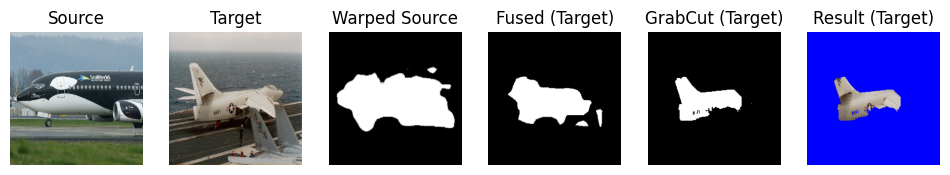

Source: ILSVRC2012_val_00001390.jpg, Target: ILSVRC2012_val_00008292.jpg
Flow stats: min: -0.932, max: 1.028, mean: -0.037
Fused (target) mask sum: 2025.195, GrabCut (target) mask sum: 510.000


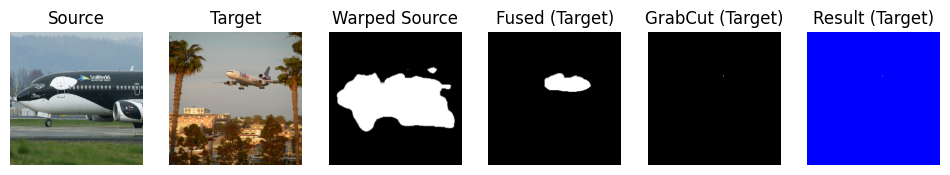

Source: ILSVRC2012_val_00001390.jpg, Target: ILSVRC2012_val_00010597.jpg
Flow stats: min: -1.022, max: 0.909, mean: -0.043
Fused (target) mask sum: 7556.723, GrabCut (target) mask sum: 1088340.000


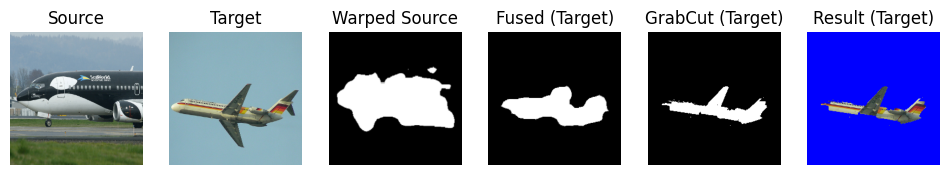

Source: ILSVRC2012_val_00001390.jpg, Target: ILSVRC2012_val_00011510.jpg
Flow stats: min: -1.048, max: 0.760, mean: -0.225
Fused (target) mask sum: 9306.798, GrabCut (target) mask sum: 1459875.000


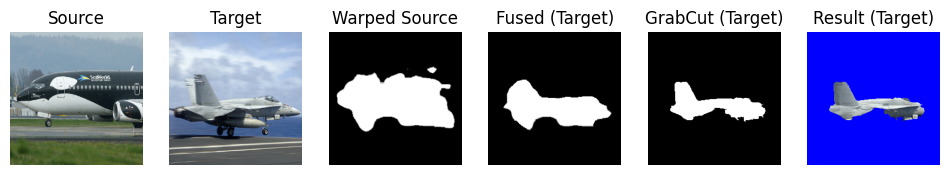

Source: ILSVRC2012_val_00001390.jpg, Target: ILSVRC2012_val_00012111.jpg
Flow stats: min: -1.024, max: 0.789, mean: -0.120
Fused (target) mask sum: 2283.658, GrabCut (target) mask sum: 240465.000


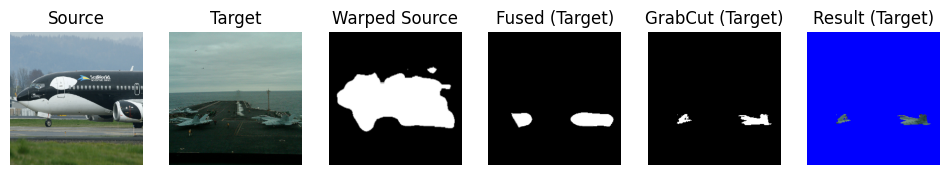

Source: ILSVRC2012_val_00001390.jpg, Target: ILSVRC2012_val_00012263.jpg
Flow stats: min: -0.949, max: 1.001, mean: 0.105
Fused (target) mask sum: 6722.528, GrabCut (target) mask sum: 677790.000


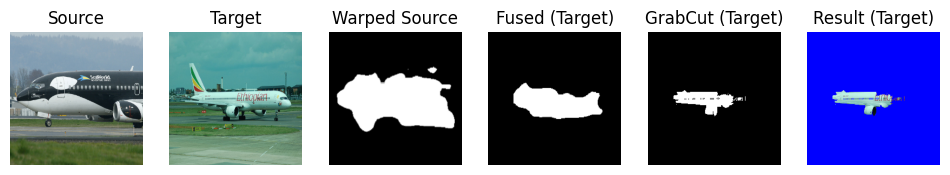

Source: ILSVRC2012_val_00001390.jpg, Target: ILSVRC2012_val_00012386.jpg
Flow stats: min: -1.012, max: 1.049, mean: -0.017
Fused (target) mask sum: 7289.175, GrabCut (target) mask sum: 22695.000


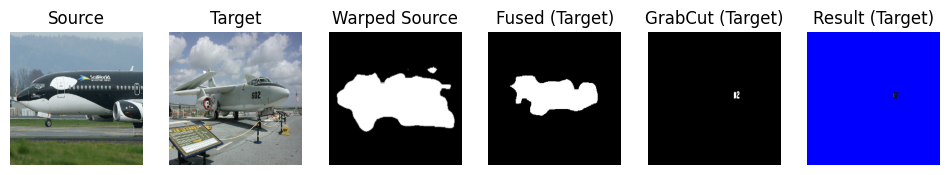

Source: ILSVRC2012_val_00001390.jpg, Target: ILSVRC2012_val_00014425.jpg
Flow stats: min: -1.018, max: 1.071, mean: -0.153
Fused (target) mask sum: 2162.431, GrabCut (target) mask sum: 2040.000


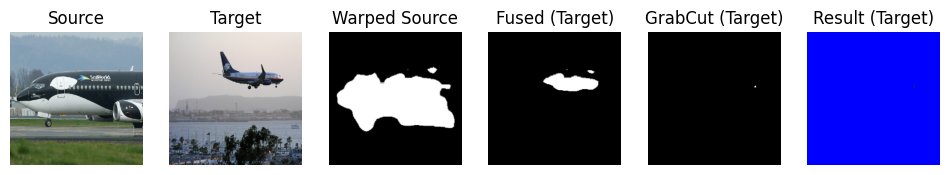

Source: ILSVRC2012_val_00001390.jpg, Target: ILSVRC2012_val_00015498.jpg
Flow stats: min: -0.913, max: 0.912, mean: -0.035
Fused (target) mask sum: 1145.761, GrabCut (target) mask sum: 67320.000


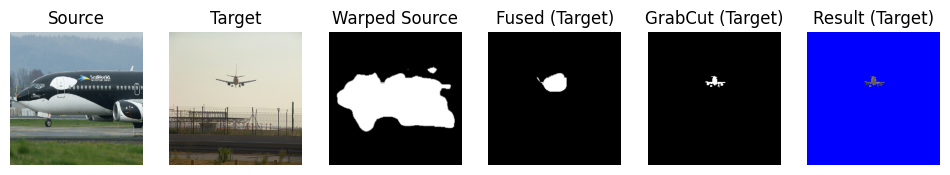

Source: ILSVRC2012_val_00001390.jpg, Target: ILSVRC2012_val_00016995.jpg
Flow stats: min: -1.052, max: 0.956, mean: -0.039
Fused (target) mask sum: 6720.183, GrabCut (target) mask sum: 847110.000


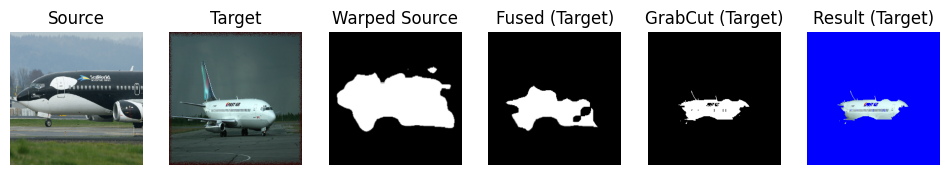

Source: ILSVRC2012_val_00001390.jpg, Target: ILSVRC2012_val_00019179.jpg
Flow stats: min: -1.048, max: 0.814, mean: -0.222
Fused (target) mask sum: 2486.650, GrabCut (target) mask sum: 23715.000


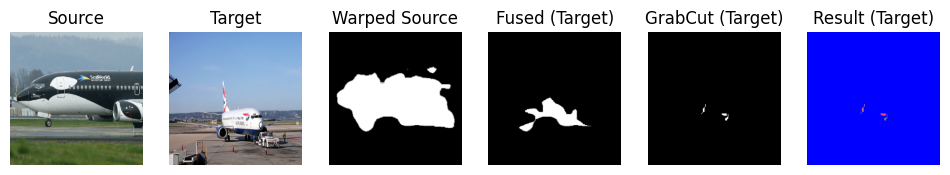

Source: ILSVRC2012_val_00001390.jpg, Target: ILSVRC2012_val_00019677.jpg
Flow stats: min: -1.055, max: 1.012, mean: -0.021
Fused (target) mask sum: 8158.554, GrabCut (target) mask sum: 1327020.000


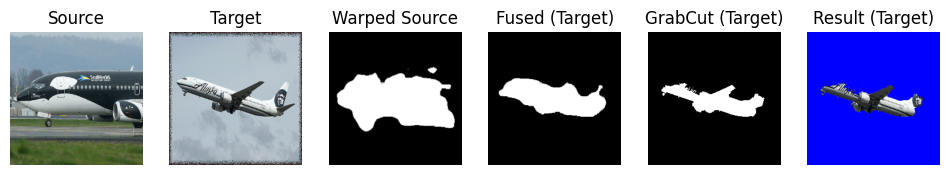

Source: ILSVRC2012_val_00001390.jpg, Target: ILSVRC2012_val_00021747.jpg
Flow stats: min: -1.071, max: 1.059, mean: 0.049
Fused (target) mask sum: 8755.479, GrabCut (target) mask sum: 769080.000


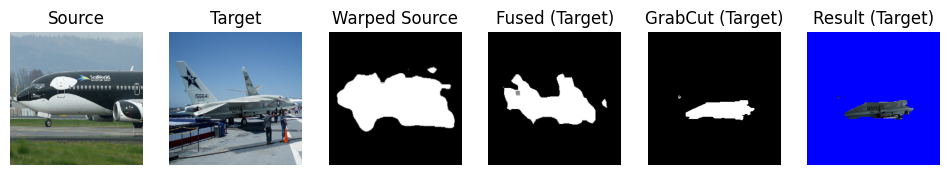

Source: ILSVRC2012_val_00001390.jpg, Target: ILSVRC2012_val_00022532.jpg
Flow stats: min: -0.996, max: 0.864, mean: -0.113
Fused (target) mask sum: 3017.756, GrabCut (target) mask sum: 62220.000


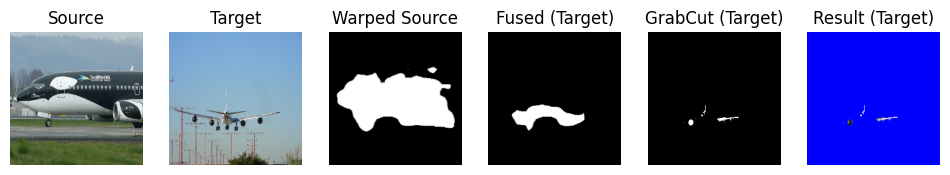

Source: ILSVRC2012_val_00001390.jpg, Target: ILSVRC2012_val_00022975.jpg
Flow stats: min: -1.030, max: 0.881, mean: -0.097
Fused (target) mask sum: 9732.250, GrabCut (target) mask sum: 1694220.000


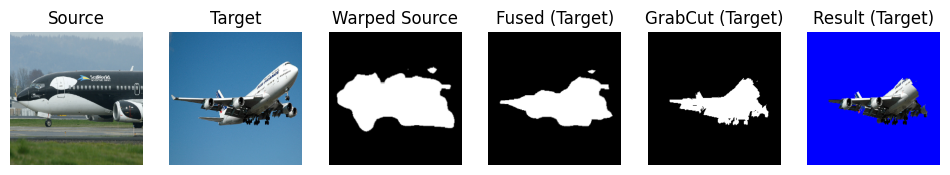

Source: ILSVRC2012_val_00001390.jpg, Target: ILSVRC2012_val_00023316.jpg
Flow stats: min: -0.961, max: 0.816, mean: -0.120
Fused (target) mask sum: 3943.014, GrabCut (target) mask sum: 352665.000


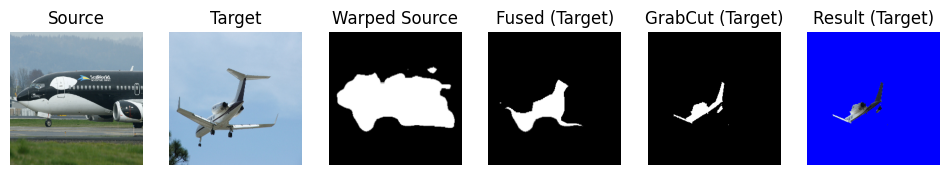

Source: ILSVRC2012_val_00001390.jpg, Target: ILSVRC2012_val_00023781.jpg
Flow stats: min: -0.908, max: 0.833, mean: -0.091
Fused (target) mask sum: 9419.350, GrabCut (target) mask sum: 1575645.000


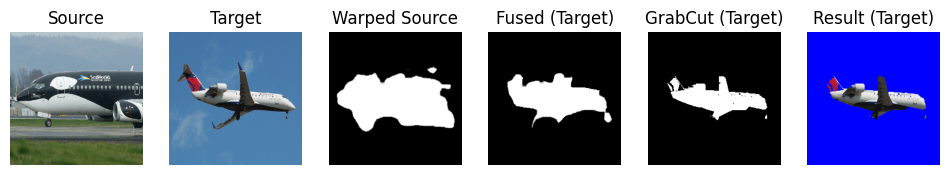

Source: ILSVRC2012_val_00001390.jpg, Target: ILSVRC2012_val_00024747.jpg
Flow stats: min: -0.934, max: 0.876, mean: -0.067
Fused (target) mask sum: 5401.202, GrabCut (target) mask sum: 154275.000


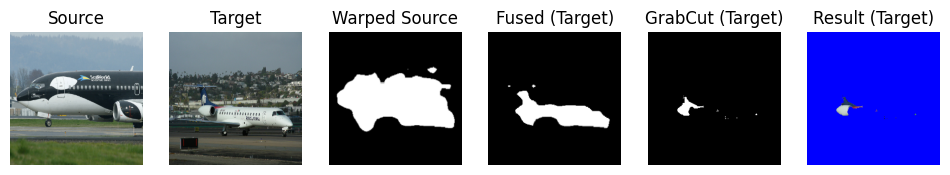

Source: ILSVRC2012_val_00001390.jpg, Target: ILSVRC2012_val_00026189.jpg
Flow stats: min: -0.996, max: 0.830, mean: -0.073
Fused (target) mask sum: 6299.414, GrabCut (target) mask sum: 527595.000


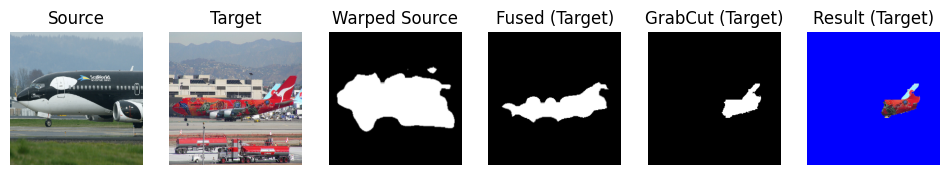

Source: ILSVRC2012_val_00001390.jpg, Target: ILSVRC2012_val_00026859.jpg
Flow stats: min: -1.093, max: 0.982, mean: -0.127
Fused (target) mask sum: 6870.429, GrabCut (target) mask sum: 1185240.000


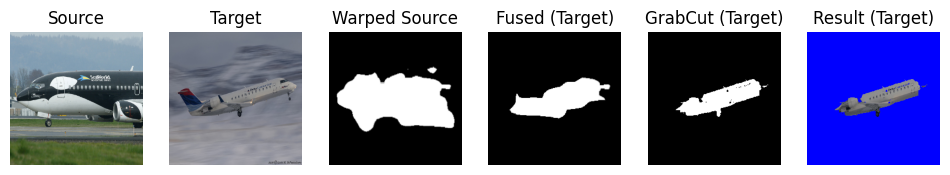

Source: ILSVRC2012_val_00001390.jpg, Target: ILSVRC2012_val_00028019.jpg
Flow stats: min: -1.024, max: 0.972, mean: -0.105
Fused (target) mask sum: 6789.085, GrabCut (target) mask sum: 365925.000


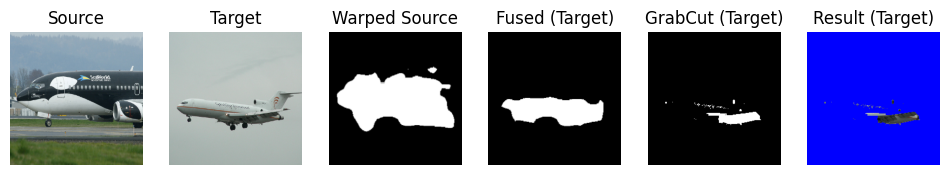

Source: ILSVRC2012_val_00001390.jpg, Target: ILSVRC2012_val_00030531.jpg
Flow stats: min: -1.052, max: 0.815, mean: -0.151
Fused (target) mask sum: 8183.815, GrabCut (target) mask sum: 1337475.000


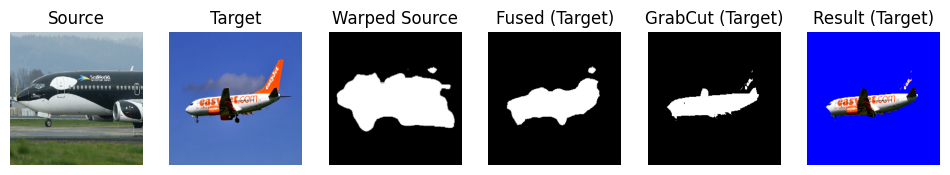

Source: ILSVRC2012_val_00001390.jpg, Target: ILSVRC2012_val_00032804.jpg
Flow stats: min: -1.168, max: 0.955, mean: 0.026
Fused (target) mask sum: 7992.256, GrabCut (target) mask sum: 0.000


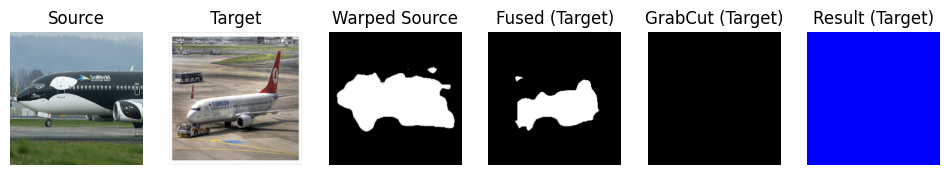

Source: ILSVRC2012_val_00001390.jpg, Target: ILSVRC2012_val_00033441.jpg
Flow stats: min: -0.938, max: 0.859, mean: -0.142
Fused (target) mask sum: 10446.502, GrabCut (target) mask sum: 88230.000


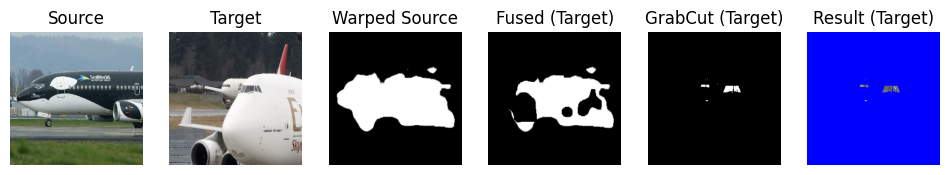

Source: ILSVRC2012_val_00001390.jpg, Target: ILSVRC2012_val_00033920.jpg
Flow stats: min: -1.012, max: 0.849, mean: -0.005
Fused (target) mask sum: 9179.273, GrabCut (target) mask sum: 1222980.000


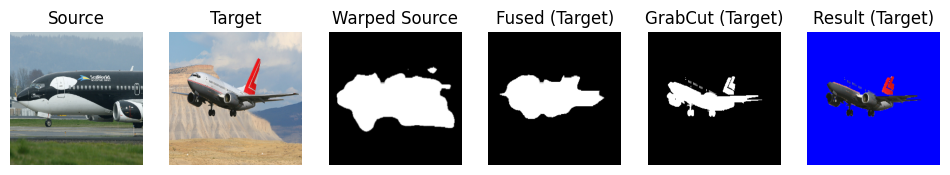

Source: ILSVRC2012_val_00001390.jpg, Target: ILSVRC2012_val_00034342.jpg
Flow stats: min: -0.995, max: 0.788, mean: -0.032
Fused (target) mask sum: 9430.276, GrabCut (target) mask sum: 1375725.000


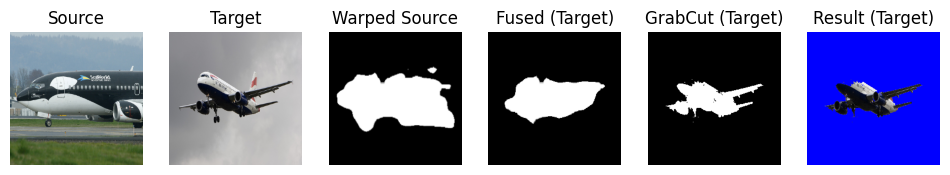

Source: ILSVRC2012_val_00001390.jpg, Target: ILSVRC2012_val_00035783.jpg
Flow stats: min: -0.905, max: 0.802, mean: -0.048
Fused (target) mask sum: 205.869, GrabCut (target) mask sum: 0.000


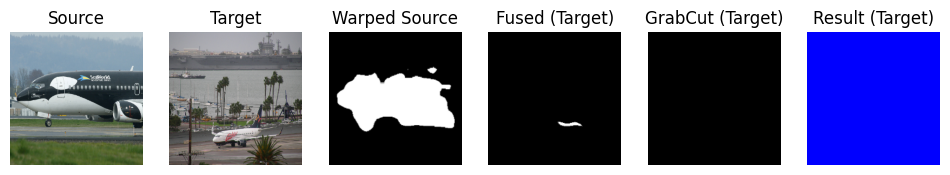

Source: ILSVRC2012_val_00001390.jpg, Target: ILSVRC2012_val_00036394.jpg
Flow stats: min: -1.060, max: 0.895, mean: -0.008
Fused (target) mask sum: 9813.392, GrabCut (target) mask sum: 1437180.000


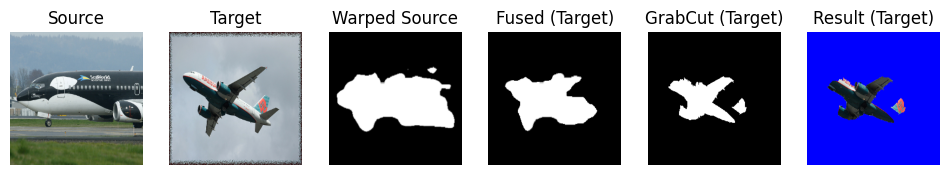

Source: ILSVRC2012_val_00001390.jpg, Target: ILSVRC2012_val_00037801.jpg
Flow stats: min: -1.031, max: 0.895, mean: -0.091
Fused (target) mask sum: 7558.879, GrabCut (target) mask sum: 1384650.000


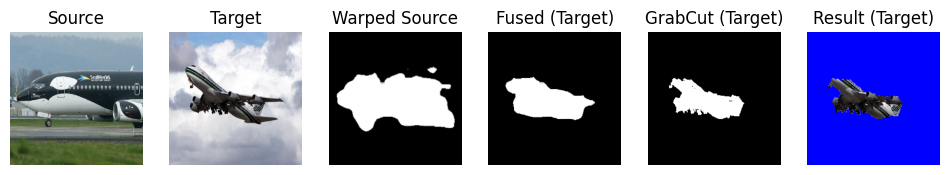

In [34]:
import os
import cv2
import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
image_dir = '/content/AMC-grounding/cosod/CoSOD3k/Image/airplane'
saliency_dir = '/content/AMC-grounding/cosod_saliency_maps/airplane'
output_dir = '/content/result'
os.makedirs(output_dir, exist_ok=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- LIST ALL IMAGE FILES ---
all_images = sorted([f for f in os.listdir(image_dir) if f.lower().endswith('.jpg')])
if len(all_images) < 2:
    raise ValueError("Need at least two images in the folder.")

# --- SOURCE IMAGE ---
source_img_name = all_images[0]
source_img_path = os.path.join(image_dir, source_img_name)
source_sal_path = os.path.join(saliency_dir, source_img_name.replace('.jpg', '_saliency.png'))

# --- LOAD SOURCE DATA ---
def load_img_and_sal(img_path, sal_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (240, 240))
    sal = cv2.imread(sal_path, cv2.IMREAD_GRAYSCALE)
    sal = cv2.resize(sal, (240, 240)) / 255.0
    return img, sal

source_img, source_sal = load_img_and_sal(source_img_path, source_sal_path)

# --- ENHANCE SOURCE SALIENCY (OPTIONAL) ---
kernel = np.ones((7,7), np.uint8)
source_sal_enh = cv2.morphologyEx(source_sal, cv2.MORPH_CLOSE, kernel)

# --- IMAGE TO TENSOR ---
def img_to_tensor(img):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    ])
    return transform(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)).unsqueeze(0).to(device)

source_tensor = img_to_tensor(source_img)

# --- WARP SOURCE SALIENCY INTO TARGET VIEW (INVERSE FLOW) ---
def warp_mask_to_target(mask, flow):
    h, w = mask.shape
    grid_x, grid_y = np.meshgrid(np.arange(w), np.arange(h))
    map_x = (grid_x - flow[...,0]).astype(np.float32)
    map_y = (grid_y - flow[...,1]).astype(np.float32)
    warped = cv2.remap(mask.astype(np.float32), map_x, map_y, cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return np.clip(warped, 0, 1)

# --- GRABCUT FUNCTION ---
def grabcut_refine(image, mask):
    mask_gc = np.where(mask > 0.5, cv2.GC_PR_FGD, cv2.GC_BGD).astype('uint8')
    bgd = np.zeros((1,65), np.float64)
    fgd = np.zeros((1,65), np.float64)
    image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    try:
        cv2.grabCut(image_bgr, mask_gc, None, bgd, fgd, 5, cv2.GC_INIT_WITH_MASK)
        result_mask = np.where((mask_gc==cv2.GC_FGD)|(mask_gc==cv2.GC_PR_FGD), 255, 0).astype('uint8')
    except:
        result_mask = (mask > 0.5).astype('uint8') * 255
    return result_mask

# --- OVERLAY FUNCTION ---
def overlay_on_blue(image, mask):
    bg = np.full_like(image, (255,0,0))
    mask_3c = np.repeat((mask > 127)[...,None], 3, axis=2)
    result = np.where(mask_3c, image, bg)
    return result

# --- LOOP OVER TARGETS ---
for target_img_name in all_images[1:]:
    target_img_path = os.path.join(image_dir, target_img_name)
    target_sal_path = os.path.join(saliency_dir, target_img_name.replace('.jpg', '_saliency.png'))

    # --- LOAD TARGET DATA ---
    target_img, target_sal = load_img_and_sal(target_img_path, target_sal_path)
    target_sal_enh = cv2.morphologyEx(target_sal, cv2.MORPH_CLOSE, kernel)
    target_tensor = img_to_tensor(target_img)

    # --- DGCNet FLOW ---
    with torch.no_grad():
        warped_output, _ = dgc_model(source_tensor, target_tensor)  # dgc_model loaded elsewhere
        flow = warped_output[-1].squeeze().permute(1,2,0).cpu().numpy()
        flow = cv2.resize(flow, (240,240))

    # --- WARP SOURCE SALIENCY INTO TARGET VIEW ---
    warped_source_sal = warp_mask_to_target(source_sal_enh, flow)

    # --- FUSE IN TARGET FRAME ---
    fused_in_target = np.sqrt(target_sal_enh * warped_source_sal)

    # --- GRABCUT ON TARGET ---
    grabcut_mask_target = grabcut_refine(target_img, fused_in_target)

    # --- FINAL RESULT ON TARGET ---
    final_result_target = overlay_on_blue(target_img, grabcut_mask_target)

    # --- PRINT DATA ---
    print(f"Source: {source_img_name}, Target: {target_img_name}")
    print(f"Flow stats: min: {flow.min():.3f}, max: {flow.max():.3f}, mean: {flow.mean():.3f}")
    print(f"Fused (target) mask sum: {fused_in_target.sum():.3f}, GrabCut (target) mask sum: {grabcut_mask_target.sum():.3f}")

    # --- SAVE OUTPUTS (OPTIONAL) ---
    cv2.imwrite(os.path.join(output_dir, f"{os.path.splitext(target_img_name)[0]}_warped_source_sal.png"), (warped_source_sal*255).astype(np.uint8))
    cv2.imwrite(os.path.join(output_dir, f"{os.path.splitext(target_img_name)[0]}_fused_target.png"), (fused_in_target*255).astype(np.uint8))
    cv2.imwrite(os.path.join(output_dir, f"{os.path.splitext(target_img_name)[0]}_grabcut_target.png"), grabcut_mask_target)
    cv2.imwrite(os.path.join(output_dir, f"{os.path.splitext(target_img_name)[0]}_result_target.png"), final_result_target)

    # --- OPTIONAL: SHOW SUMMARY ---
    plt.figure(figsize=(12,4))
    titles = ["Source", "Target", "Warped Source", "Fused (Target)", "GrabCut (Target)", "Result (Target)"]
    images = [source_img, target_img, warped_source_sal, fused_in_target, grabcut_mask_target, final_result_target]
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1,6,i+1)
        if img.ndim==3:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(img, cmap='gray')
        plt.title(title); plt.axis('off')
    plt.show()

In [35]:
warped_output

[tensor([[[[-6.4610e-01, -6.0403e-01, -5.7188e-01, -5.0249e-01, -3.5212e-01,
            -1.9422e-01,  3.3108e-02,  1.6280e-02, -7.6091e-04,  5.5771e-02,
             2.4603e-01,  3.8469e-01,  5.3642e-01,  6.6811e-01,  6.6451e-01],
           [-6.7716e-01, -6.5785e-01, -6.0005e-01, -5.2512e-01, -3.8060e-01,
            -1.9625e-01,  1.1985e-01,  1.2805e-01,  1.6079e-01,  2.0044e-01,
             3.8148e-01,  4.9673e-01,  5.6539e-01,  6.7071e-01,  7.0088e-01],
           [-7.2928e-01, -6.9921e-01, -5.9678e-01, -5.2268e-01, -3.6467e-01,
            -1.6727e-01,  1.3880e-01,  2.6004e-01,  3.6510e-01,  3.6141e-01,
             4.9284e-01,  5.8574e-01,  6.2596e-01,  6.9691e-01,  7.1836e-01],
           [-8.1580e-01, -7.7144e-01, -6.3196e-01, -5.4398e-01, -4.2030e-01,
            -2.2809e-01,  1.9793e-02,  2.4396e-01,  3.9079e-01,  4.0819e-01,
             5.0083e-01,  5.6771e-01,  6.0542e-01,  6.9351e-01,  7.3113e-01],
           [-8.8678e-01, -8.3986e-01, -6.8253e-01, -5.5771e-01, -3.7925e

In [37]:
import os
import cv2
import torch
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from glob import glob

# ---- Setup ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_dir = '/content/AMC-grounding/cosod/CoSOD3k/Image/airplane'
saliency_dir = '/content/AMC-grounding/cosod_saliency_maps/airplane'
output_dir = '/content/AMC-grounding/results/airplane'
os.makedirs(output_dir, exist_ok=True)

# ---- Load DGCNet ----
dgc_model = dgc_model.to(device)
dgc_model.eval()

# ---- Utility functions ----
def load_image_and_tensor(path):
    img = cv2.imread(path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (240, 240))
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    tensor = transform(img_resized).unsqueeze(0).to(device)
    return tensor, img_resized

def load_saliency(path, shape):
    sal = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    sal = cv2.resize(sal, shape[::-1])  # shape: (W, H)
    sal = sal / 255.0
    return sal

def warp_saliency_with_flow(saliency, flow):
    h, w = saliency.shape
    flow_map = np.stack(np.meshgrid(np.arange(w), np.arange(h)), axis=-1).astype(np.float32)
    warped_coords = flow_map + flow
    warped = cv2.remap(saliency.astype(np.float32), warped_coords[..., 0], warped_coords[..., 1], cv2.INTER_LINEAR)
    return np.clip(warped, 0, 1)

def fuse_saliency(sal1, sal2):
    return np.sqrt(sal1 * sal2)

def apply_grabcut(image, saliency):
    mask = np.where(saliency > 0.5, cv2.GC_PR_FGD, cv2.GC_BGD).astype('uint8')
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    try:
        cv2.grabCut(image, mask, None, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_MASK)
        result_mask = np.where((mask == cv2.GC_FGD) | (mask == cv2.GC_PR_FGD), 255, 0).astype('uint8')
        return result_mask
    except:
        return np.zeros_like(saliency, dtype='uint8')

# ---- Source Image ----
source_img_path = sorted(glob(os.path.join(image_dir, '*.jpg')))[0]  # Use first image as source
source_tensor, source_resized = load_image_and_tensor(source_img_path)
source_filename = os.path.basename(source_img_path)
source_sal_path = os.path.join(saliency_dir, source_filename.replace('.jpg', '_saliency.png'))
source_sal = load_saliency(source_sal_path, source_resized.shape[:2])

# ---- Process each target image ----
all_images = sorted(glob(os.path.join(image_dir, '*.jpg')))
for target_img_path in all_images:
    if target_img_path == source_img_path:
        continue

    target_tensor, target_resized = load_image_and_tensor(target_img_path)
    target_filename = os.path.basename(target_img_path)
    target_sal_path = os.path.join(saliency_dir, target_filename.replace('.jpg', '_saliency.png'))
    target_sal = load_saliency(target_sal_path, target_resized.shape[:2])

    with torch.no_grad():
        warped_output, _ = dgc_model(source_tensor, target_tensor)
        flow = warped_output[-1].squeeze().permute(1, 2, 0).cpu().numpy()
        flow = cv2.resize(flow, (240, 240))

    # --- Warp target saliency map to source ---
    warped_sal = warp_saliency_with_flow(target_sal, flow)

    # --- Fuse with original saliency (geometric mean) ---
    fused_sal = fuse_saliency(source_sal, warped_sal)

    # --- GrabCut on source and target ---
    grabcut_source = apply_grabcut(source_resized, fused_sal)
    grabcut_target = apply_grabcut(target_resized, target_sal)

    # --- Save result ---
    combined = np.hstack([
        source_resized,
        cv2.cvtColor((fused_sal * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB),
        cv2.cvtColor(grabcut_source, cv2.COLOR_GRAY2RGB),
        target_resized,
        cv2.cvtColor(grabcut_target, cv2.COLOR_GRAY2RGB)
    ])
    save_path = os.path.join(output_dir, f'{os.path.splitext(target_filename)[0]}_result.png')
    cv2.imwrite(save_path, cv2.cvtColor(combined, cv2.COLOR_RGB2BGR))
    print(f"Saved: {save_path}")

Saved: /content/AMC-grounding/results/airplane/ILSVRC2012_val_00004089_result.png
Saved: /content/AMC-grounding/results/airplane/ILSVRC2012_val_00008292_result.png
Saved: /content/AMC-grounding/results/airplane/ILSVRC2012_val_00010597_result.png
Saved: /content/AMC-grounding/results/airplane/ILSVRC2012_val_00011510_result.png
Saved: /content/AMC-grounding/results/airplane/ILSVRC2012_val_00012111_result.png
Saved: /content/AMC-grounding/results/airplane/ILSVRC2012_val_00012263_result.png
Saved: /content/AMC-grounding/results/airplane/ILSVRC2012_val_00012386_result.png
Saved: /content/AMC-grounding/results/airplane/ILSVRC2012_val_00014425_result.png
Saved: /content/AMC-grounding/results/airplane/ILSVRC2012_val_00015498_result.png
Saved: /content/AMC-grounding/results/airplane/ILSVRC2012_val_00016995_result.png
Saved: /content/AMC-grounding/results/airplane/ILSVRC2012_val_00019179_result.png
Saved: /content/AMC-grounding/results/airplane/ILSVRC2012_val_00019677_result.png
Saved: /content/

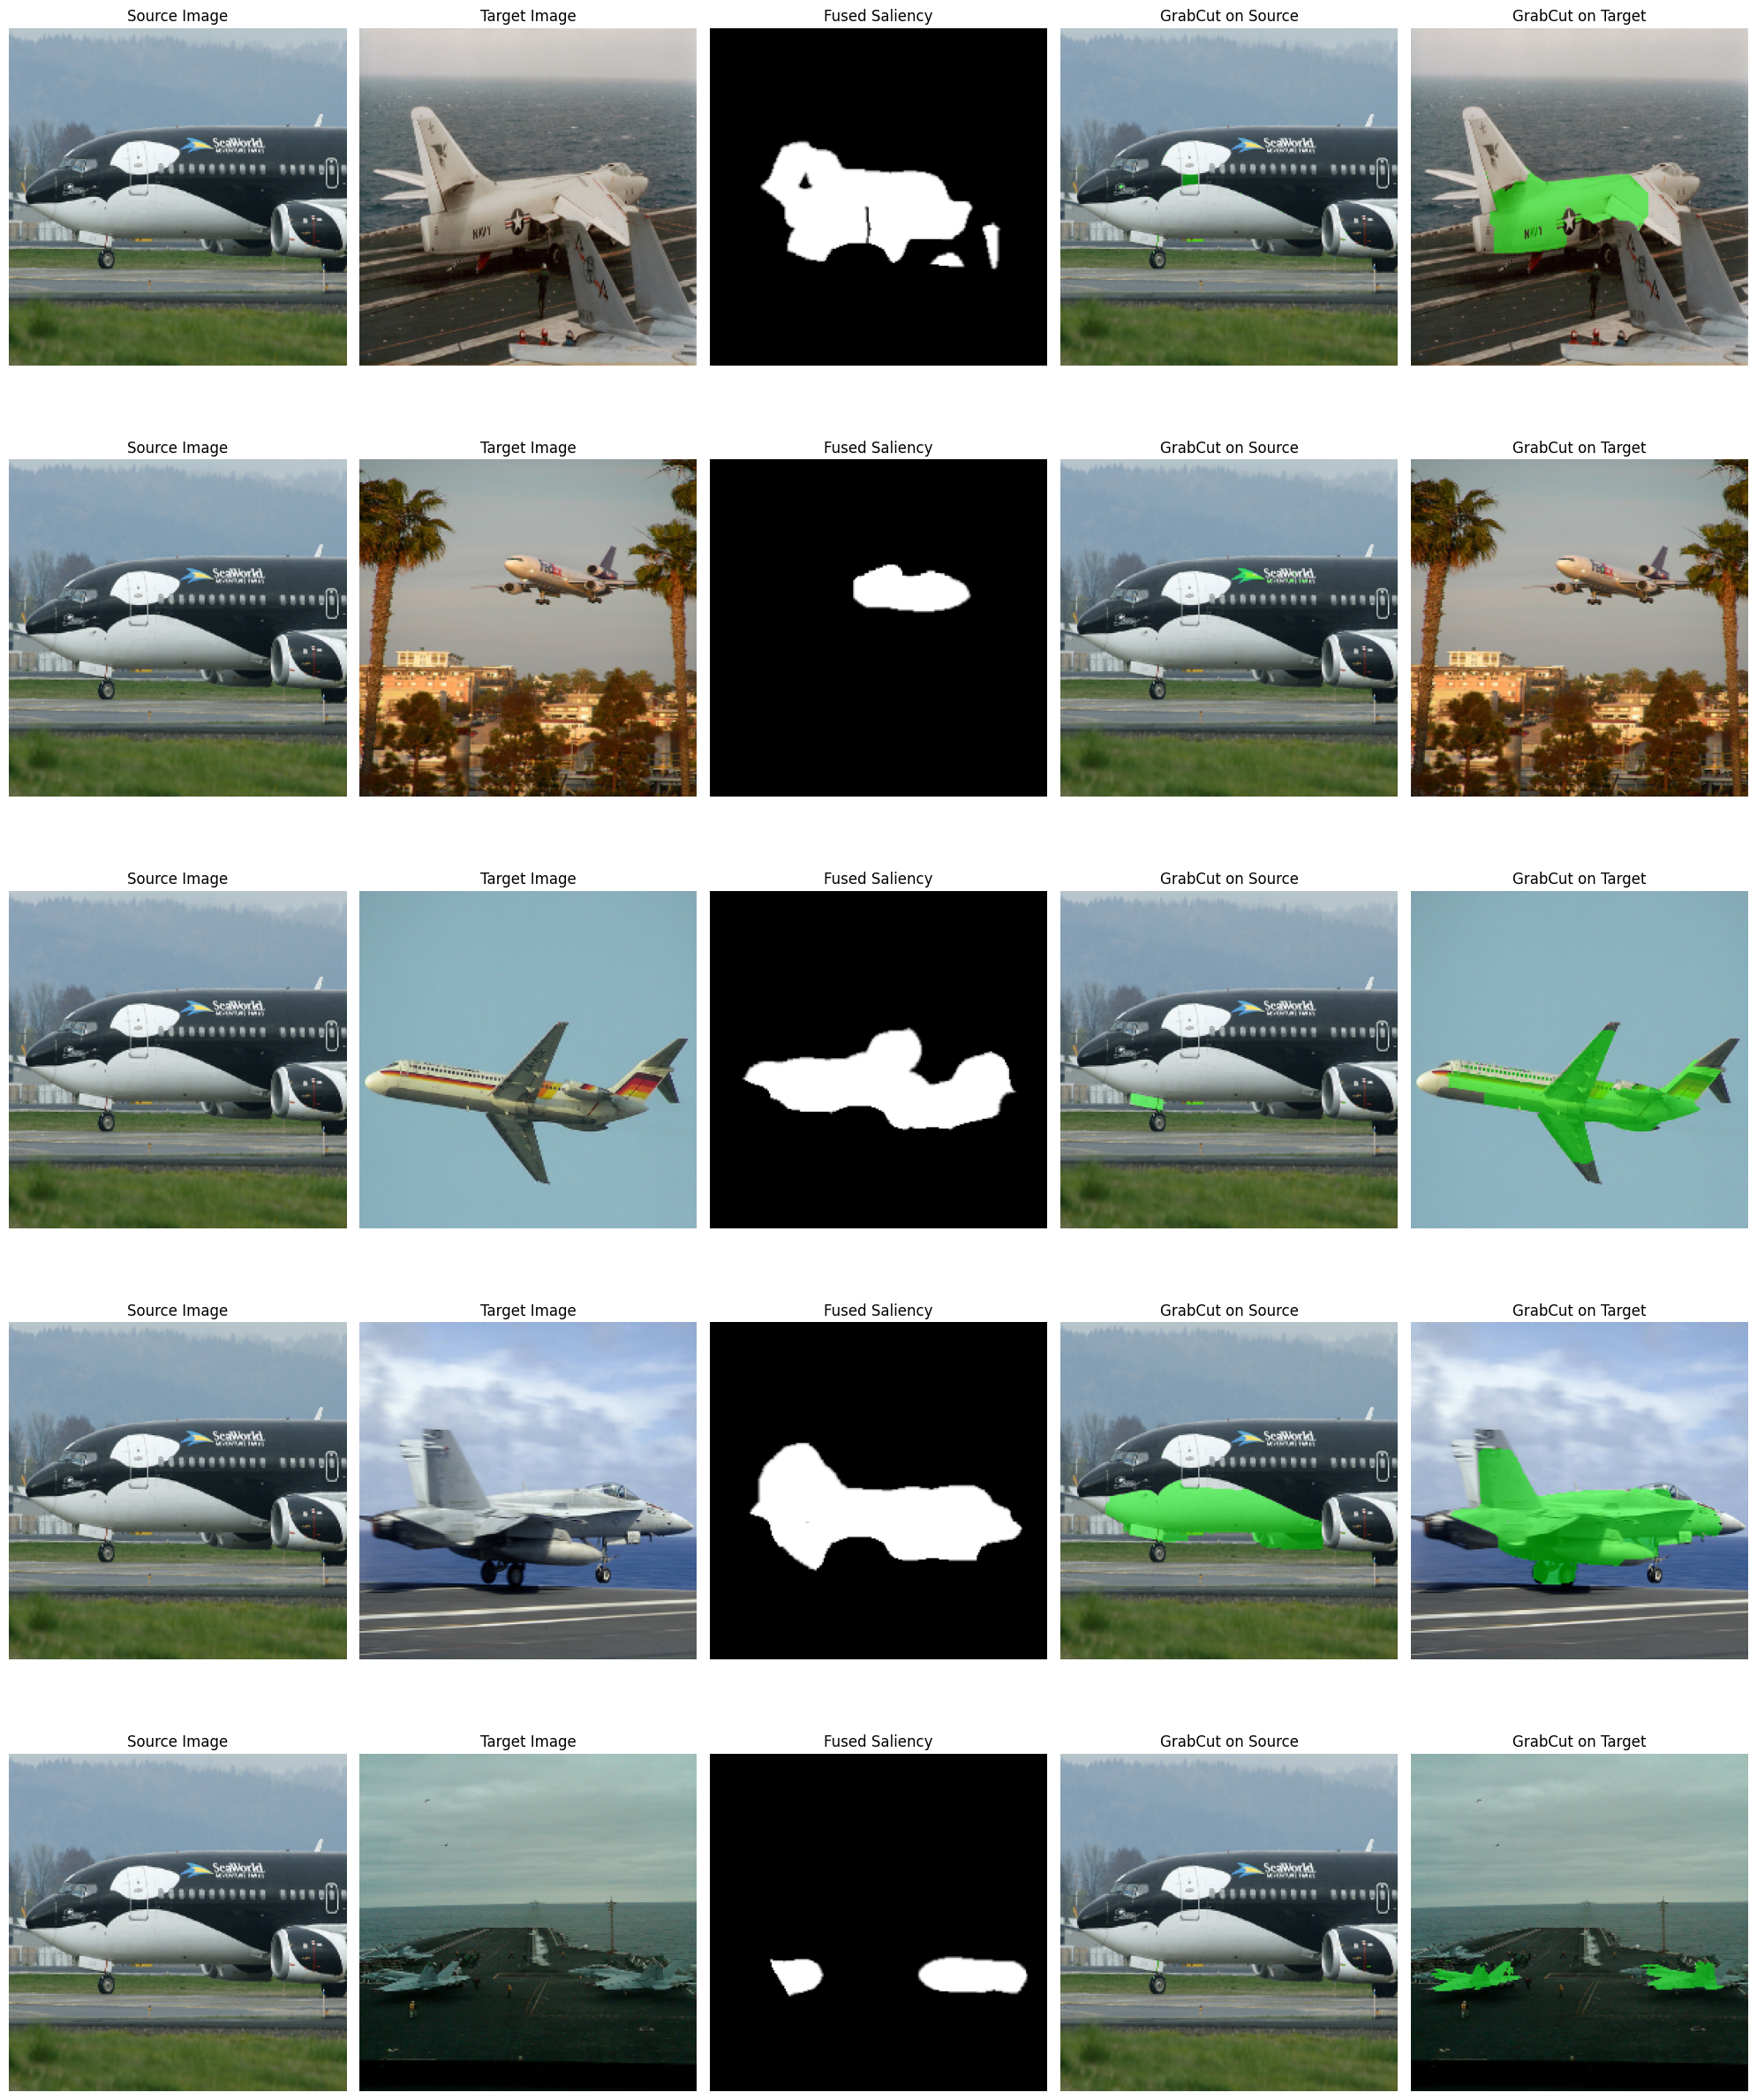

In [38]:
import matplotlib.pyplot as plt

def overlay_mask_on_image(image, mask, alpha=0.5, color=(0, 255, 0)):
    overlay = image.copy()
    mask_bool = mask.astype(bool)
    overlay[mask_bool] = cv2.addWeighted(image[mask_bool], 1 - alpha, np.full_like(image[mask_bool], color), alpha, 0)
    return overlay

# Collect results for plotting
visual_results = []
image_counter = 0

all_images = sorted(glob(os.path.join(image_dir, '*.jpg')))
for target_img_path in all_images:
    if target_img_path == source_img_path:
        continue

    target_tensor, target_resized = load_image_and_tensor(target_img_path)
    target_filename = os.path.basename(target_img_path)
    target_sal_path = os.path.join(saliency_dir, target_filename.replace('.jpg', '_saliency.png'))
    target_sal = load_saliency(target_sal_path, target_resized.shape[:2])

    with torch.no_grad():
        warped_output, _ = dgc_model(source_tensor, target_tensor)
        flow = warped_output[-1].squeeze().permute(1, 2, 0).cpu().numpy()
        flow = cv2.resize(flow, (240, 240))

    warped_sal = warp_saliency_with_flow(target_sal, flow)
    fused_sal = fuse_saliency(source_sal, warped_sal)

    grabcut_source = apply_grabcut(source_resized, fused_sal)
    grabcut_target = apply_grabcut(target_resized, target_sal)

    # Prepare overlays
    overlay_src = overlay_mask_on_image(source_resized, grabcut_source // 255)
    overlay_tgt = overlay_mask_on_image(target_resized, grabcut_target // 255)

    visual_results.append({
        "src": source_resized,
        "tgt": target_resized,
        "fused_sal": fused_sal,
        "overlay_src": overlay_src,
        "overlay_tgt": overlay_tgt
    })

    image_counter += 1
    if image_counter >= 5:
        break

# Plot
fig, axs = plt.subplots(len(visual_results), 5, figsize=(20, 5 * len(visual_results)))
for i, res in enumerate(visual_results):
    axs[i, 0].imshow(res["src"])
    axs[i, 0].set_title("Source Image")
    axs[i, 1].imshow(res["tgt"])
    axs[i, 1].set_title("Target Image")
    axs[i, 2].imshow(res["fused_sal"], cmap='gray')
    axs[i, 2].set_title("Fused Saliency")
    axs[i, 3].imshow(res["overlay_src"])
    axs[i, 3].set_title("GrabCut on Source")
    axs[i, 4].imshow(res["overlay_tgt"])
    axs[i, 4].set_title("GrabCut on Target")

for ax in axs.flat:
    ax.axis('off')
plt.tight_layout()
plt.show()

In [39]:
import os
import cv2
import torch
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from glob import glob

# ---- Setup ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_dir = '/content/AMC-grounding/cosod/CoSOD3k/Image/airplane'
saliency_dir = '/content/AMC-grounding/cosod_saliency_maps/airplane'
output_dir = '/content/AMC-grounding/results/airplane_visualization'
os.makedirs(output_dir, exist_ok=True)

# ---- Load DGCNet ----
dgc_model = dgc_model.to(device)
dgc_model.eval()

# ---- Utility functions ----
def load_image_and_tensor(path):
    img = cv2.imread(path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (240, 240))
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    tensor = transform(img_resized).unsqueeze(0).to(device)
    return tensor, img_resized

def load_saliency(path, shape):
    sal = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    sal = cv2.resize(sal, shape[::-1])  # shape: (H, W)
    sal = sal / 255.0
    return sal

def warp_saliency_with_flow(saliency, flow):
    h, w = saliency.shape
    grid_x, grid_y = np.meshgrid(np.arange(w), np.arange(h))
    map_x = (grid_x + flow[..., 0]).astype(np.float32)
    map_y = (grid_y + flow[..., 1]).astype(np.float32)
    warped = cv2.remap(saliency.astype(np.float32), map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return np.clip(warped, 0, 1)

def fuse_saliency(sal1, sal2):
    return np.sqrt(sal1 * sal2)

def apply_grabcut(image, saliency):
    mask = np.where(saliency > 0.5, cv2.GC_PR_FGD, cv2.GC_BGD).astype('uint8')
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    try:
        cv2.grabCut(image, mask, None, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_MASK)
        result_mask = np.where((mask == cv2.GC_FGD) | (mask == cv2.GC_PR_FGD), 255, 0).astype('uint8')
        return result_mask
    except:
        return np.zeros_like(saliency, dtype='uint8')

# ---- Source image ----
source_img_path = sorted(glob(os.path.join(image_dir, '*.jpg')))[0]
source_tensor, source_resized = load_image_and_tensor(source_img_path)
source_filename = os.path.basename(source_img_path)
source_sal_path = os.path.join(saliency_dir, source_filename.replace('.jpg', '_saliency.png'))
source_sal = load_saliency(source_sal_path, source_resized.shape[:2])

# ---- Process each target image ----
all_images = sorted(glob(os.path.join(image_dir, '*.jpg')))
for target_img_path in all_images:
    if target_img_path == source_img_path:
        continue

    target_tensor, target_resized = load_image_and_tensor(target_img_path)
    target_filename = os.path.basename(target_img_path)
    target_sal_path = os.path.join(saliency_dir, target_filename.replace('.jpg', '_saliency.png'))
    target_sal = load_saliency(target_sal_path, target_resized.shape[:2])

    with torch.no_grad():
        warped_output, _ = dgc_model(source_tensor, target_tensor)
        flow = warped_output[-1].squeeze().permute(1, 2, 0).cpu().numpy()  # [H, W, 2]

    # --- Warp target saliency map to source space ---
    warped_sal = warp_saliency_with_flow(target_sal, flow)

    # --- Fuse saliency maps ---
    fused_sal = fuse_saliency(source_sal, warped_sal)

    # --- Apply GrabCut segmentation ---
    grabcut_mask = apply_grabcut(source_resized, fused_sal)

    # --- Visualize results side by side like paper figure ---
    def to_gray_rgb(arr):
        return cv2.cvtColor((arr * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)

    visualization_row = np.hstack([
        source_resized,
        target_resized,
        to_gray_rgb(source_sal),
        to_gray_rgb(target_sal),
        to_gray_rgb(warped_sal),
        to_gray_rgb(fused_sal),
        cv2.cvtColor(grabcut_mask, cv2.COLOR_GRAY2RGB)
    ])

    save_path = os.path.join(output_dir, f"{os.path.splitext(target_filename)[0]}_visual.png")
    cv2.imwrite(save_path, cv2.cvtColor(visualization_row, cv2.COLOR_RGB2BGR))
    print(f"Saved: {save_path}")

Saved: /content/AMC-grounding/results/airplane_visualization/ILSVRC2012_val_00004089_visual.png
Saved: /content/AMC-grounding/results/airplane_visualization/ILSVRC2012_val_00008292_visual.png
Saved: /content/AMC-grounding/results/airplane_visualization/ILSVRC2012_val_00010597_visual.png
Saved: /content/AMC-grounding/results/airplane_visualization/ILSVRC2012_val_00011510_visual.png
Saved: /content/AMC-grounding/results/airplane_visualization/ILSVRC2012_val_00012111_visual.png
Saved: /content/AMC-grounding/results/airplane_visualization/ILSVRC2012_val_00012263_visual.png
Saved: /content/AMC-grounding/results/airplane_visualization/ILSVRC2012_val_00012386_visual.png
Saved: /content/AMC-grounding/results/airplane_visualization/ILSVRC2012_val_00014425_visual.png
Saved: /content/AMC-grounding/results/airplane_visualization/ILSVRC2012_val_00015498_visual.png
Saved: /content/AMC-grounding/results/airplane_visualization/ILSVRC2012_val_00016995_visual.png
Saved: /content/AMC-grounding/results/ai

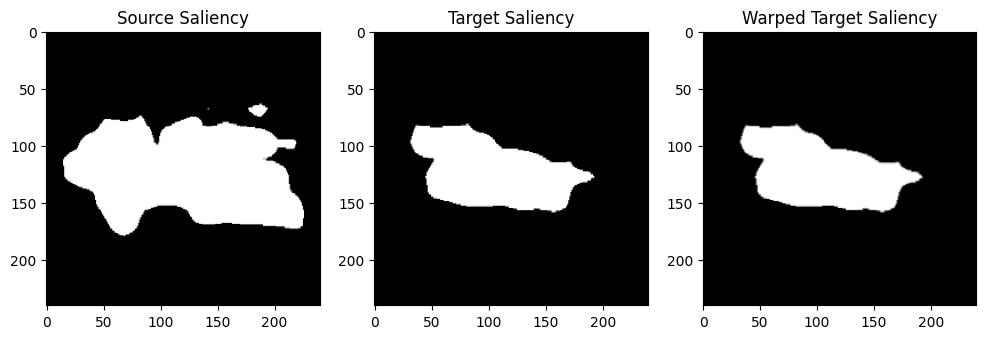

In [40]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Source Saliency")
plt.imshow(source_sal, cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Target Saliency")
plt.imshow(target_sal, cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Warped Target Saliency")
plt.imshow(warped_sal, cmap='gray')
plt.show()